# Image inpainting

Example of image inpainting using NIHT


In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import cv2

import pylops

from nopt.transforms import *
from nopt.constraints import *
from nopt.problems import *
from nopt.solvers import *

In [2]:
# Load image
img = cv2.imread('../data/cameraman.jpg', 0) 

delta = 0.5
rho = 0.1
p = round(delta * 512**2) # number of samples
s = round(p * rho) # sparsity

mask = np.random.choice(512**2,p,replace = False)
P_omega = EntryWise((len(mask),512**2), mask)
Wave2d = pylops.signalprocessing.DWT2D(img.shape, level=2, wavelet = 'db4')

img_coeff = Wave2d.matvec(img.flatten())

The model is
$$ \min_c \| P_\Omega( \Psi^*(c) )) - b \|_2 \qquad \mathrm{s.t.}\qquad \|c\|_0 \leq s$$
where $P_\Omega$ is an entrywise subsampling and $\Psi$ is an 2D Wavelet transform.

In [3]:
A = CompositeTransform([Wave2d.adjoint(), P_omega])
HTs = Sparsity(s)
b = P_omega.matvec(img.flatten())

sub, x_true = HTs.project(img_coeff)
problem = LinearProblem(A, b, HTs, x_true = x_true)
solver = NIHT(logverbosity = 2, maxiter = 100)

In [4]:
x, opt_log = solver.solve(problem)

Terminated - max iterations reached after 13.97 seconds.



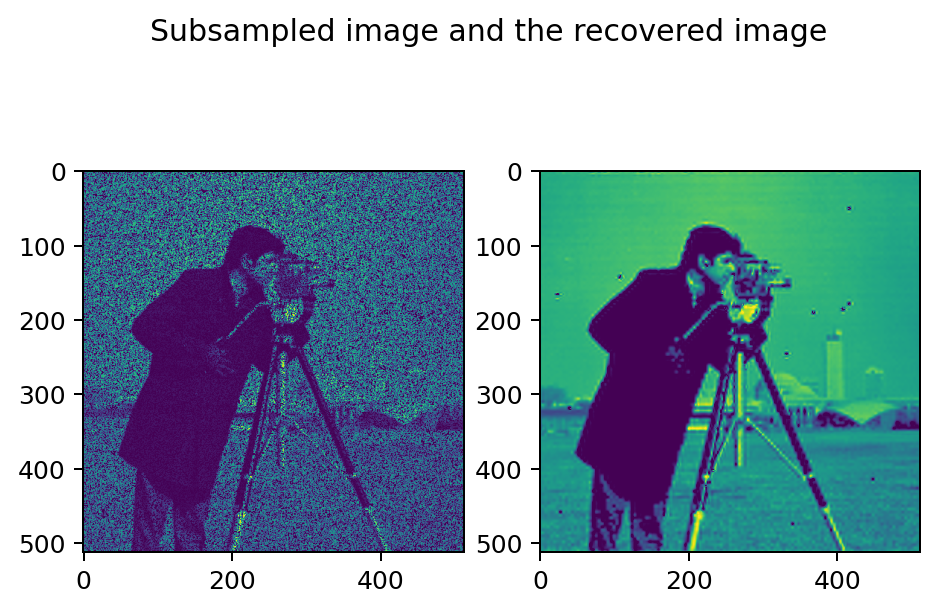

In [5]:
fig, axs = plt.subplots(1,2, dpi=180)
fig.suptitle('Subsampled image and the recovered image')
plt1 = axs[0].imshow(P_omega.rmatvec(b).reshape(512,512), vmin = 0, vmax=256)
plt2 = axs[1].imshow(Wave2d.rmatvec(x).reshape(512,512), vmin = 0, vmax=256)
fig.show()

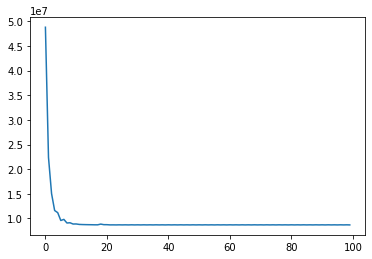

In [7]:
plt.plot(opt_log['iterations']['fx'])